# Titanic : (GridSearch, RandomSearch, optuna)
- on repart des fichiers cleaning_ml_course_iterative_inputer.ipynb
- on optimise les paramètres des modèles construits avec trois approches:
    - gridsearchcv
    - randomsearchcv
    - optuna

%pip install scikit-optimize

%pip install optuna

%pip install tensorflow-cpu 

%pip install seaborn

%pip install scikeras

%pip install joblib

%pip install xgboost

In [37]:
#imports de base
import time
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#imports des éléments nécessaires de keras pour construire un cnn (convolutionnal neural network)
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold,RepeatedKFold,LeaveOneOut,LeavePOut,StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import optuna
from xgboost import XGBClassifier
from scipy.stats import randint,uniform

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#import des données d'entraînement
data=pd.read_csv('ntrain.csv')

### Merci chat gpt
The ROC AUC (Receiver Operating Characteristic - Area Under the Curve) curve is a performance measurement for classification models, especially binary classifiers. It visually represents how well a model can distinguish between positive and negative classes by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at different threshold levels.

Here's a breakdown:

ROC Curve: This plot shows TPR (sensitivity or recall) versus FPR (1 - specificity) at various thresholds. Each point on the curve corresponds to a different threshold, indicating a trade-off between correctly identifying positives and minimizing false positives.

AUC (Area Under the Curve): The area under the ROC curve provides a single scalar value representing the model’s ability to discriminate between classes.

AUC values range from 0 to 1.
AUC = 1 indicates perfect classification.
AUC = 0.5 suggests the model is no better than random guessing.
AUC < 0.5 means the model performs worse than random guessing, likely due to inverted class predictions.
The ROC AUC is especially useful when:

You need to assess the performance of a binary classifier.
Class distributions are imbalanced since AUC is generally unaffected by class imbalance.
In machine learning workflows, the ROC AUC score is often used as a metric to evaluate models and optimize hyperparameters, as it provides a clear and quantifiable measure of model performance.

Bibliothèques à installer : 
- pip install tensorflow-cpu
- pip install optuna

In [31]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["Survived"]), data.Survived, test_size=0.3, random_state=0)

print(X_test.head())

       Pont_A    Pont_B    Pont_C    Pont_D    Pont_E    Pont_F    Pont_G  \
495 -0.214599 -0.952933 -1.575789 -0.037470  1.681988  0.853416  2.299351   
648 -1.064093 -0.349310 -1.146278 -0.797206  2.070316  0.479671  2.728677   
278 -1.971292 -0.941317 -0.369896  0.111996  0.260898  4.128603  0.512306   
31  -0.342997  2.131119 -0.609208 -0.457265 -0.504695 -0.235702 -0.123560   
255 -0.095498 -0.406441 -0.715778 -0.671930  0.104545  0.831294  4.356460   

     Pont_T    NumCab    Ticket  ...    victor   walter   william  williams  \
495     0.0 -0.726096 -0.453713  ... -0.102783 -0.07913 -0.269464 -0.088475   
648     0.0 -0.320574 -0.456695  ... -0.102783 -0.07913 -0.269464 -0.088475   
278     0.0 -0.244828  0.150446  ... -0.102783 -0.07913 -0.269464 -0.088475   
31      0.0  0.828949 -0.429958  ... -0.102783 -0.07913  2.800383 -0.088475   
255     0.0 -0.404236 -0.453676  ... -0.102783 -0.07913 -0.269464 -0.088475   

     PassengerId    Pclass       Age     SibSp     Parch      

## Première approche: optimiser LogisticRegression avec GridSearchCV

In [5]:
#On affiche les paramètres optimisables de notre modèle (doc sklearn, merci chat gpt)
logistic_regression_params = {
    "penalty": (str, ["l1", "l2", "elasticnet", "none"]),  # Regularization term
    "dual": (bool, [True, False]),                         # Dual or primal formulation
    "tol": (float, (1e-5, 1e-2)),                          # Tolerance for convergence
    "C": (float, (0.01, 100.0)),                           # Inverse of regularization strength
    "fit_intercept": (bool, [True, False]),                # Whether to fit the intercept
    "intercept_scaling": (float, (1.0, 10.0)),             # Intercept scaling (only for `liblinear` when fit_intercept=True)
    "class_weight": (str, ["balanced", None]),             # Class weight for handling imbalance
    "solver": (str, ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),  # Solver choice
    "max_iter": (int, (100, 1000)),                        # Maximum number of iterations
    "multi_class": (str, ["auto", "ovr", "multinomial"]),  # Multi-class strategy
    "l1_ratio": (float, (0.0, 1.0))                        # Elastic-net mixing parameter (only for `elasticnet`)
}


In [6]:
#voici un exemple de grille de recherche paramétrique, normalement, il faut vérifier les comptatibilités
param_grid = {
    "penalty": ["l1", "l2"],             # Regularization types
    "C": [0.01, 0.1, 1.0, 10.0, 100.0],                # Inverse regularization strength
    "solver": ["liblinear", "saga"],          # Solvers for different penalties
    "max_iter": [500,1000,2000],                       # Number of iterations
    "tol": [1e-4, 1e-3, 1e-2],                         # Tolerance for stopping criteria
    "class_weight": ["balanced", None],                # Class weight for imbalanced datasets        
}        
nb_params=np.prod([len(v) for v in param_grid.values()])
print(f"Le nombre de combinaisons paramétriques s'élève à {nb_params}!")
print("Avec CV search, CV=5, ça multiplie par 5 le nombre d'évaluations de modèle.")

Le nombre de combinaisons paramétriques s'élève à 360!
Avec CV search, CV=5, ça multiplie par 5 le nombre d'évaluations de modèle.


In [7]:
#ensuite on instantie notre GridSerachCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(), 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1)

In [8]:
#ensuite on recherche les meilleurs paramètres
%time grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

CPU times: user 2.98 s, sys: 535 ms, total: 3.52 s
Wall time: 1min 6s


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'class_weight': ['balanced', None],
                         'max_iter': [500, 1000, 2000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga'],
                         'tol': [0.0001, 0.001, 0.01]},
             scoring='accuracy', verbose=1)

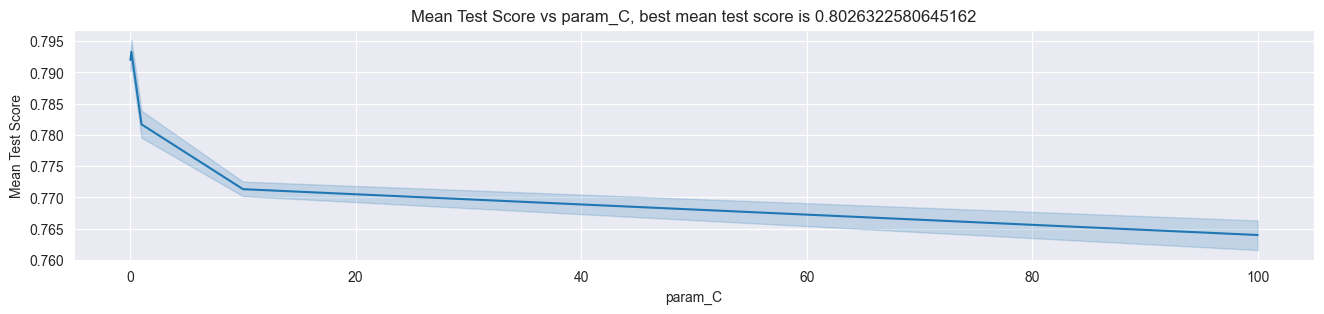

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_max_iter,param_penalty,param_solver,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
104,0.025416,0.002586,0.005476,0.000581,0.1,balanced,2000,l2,liblinear,0.01,"{'C': 0.1, 'class_weight': 'balanced', 'max_it...",0.8,0.8,0.768,0.806452,0.83871,0.802632,0.022492,55
92,0.027004,0.006201,0.007867,0.003104,0.1,balanced,1000,l2,liblinear,0.01,"{'C': 0.1, 'class_weight': 'balanced', 'max_it...",0.8,0.8,0.768,0.806452,0.83871,0.802632,0.022492,55


In [9]:
# Assuming grid_search is your GridSearchCV instance
results = pd.DataFrame(grid_search.cv_results_)
results.dropna(axis=0,inplace=True)
results.sort_values(by=['mean_test_score'],ascending=False,inplace=True)
param_name = 'param_C'  # Replace with the name of your hyperparameter
plt.figure(figsize=(16,3))
sns.lineplot(x=results[param_name].astype(float), y=results['mean_test_score'])
plt.xlabel(param_name)
plt.ylabel('Mean Test Score')
plt.title(f'Mean Test Score vs {param_name}, best mean test score is {max(results.mean_test_score)}')
plt.show()


results.head(2)

In [10]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
Best Score: 0.8235483870967742


In [11]:
grid_search.best_estimator_

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear',
                   tol=0.001)

## Deuxième approchae : avec RandomizedSearchCV
- ici on précise des range pour choisir des paramètres et on précise niter qui va dire au programme de faire niter tirages aléatoires de combinaisons paramétriques parmis les choix spécifiés dans "param_distribution"

In [12]:
param_distribution = {
    "penalty": ["l1", "l2"],             # Regularization types
    "C": np.arange(0.05,0.2,0.01),                # Inverse regularization strength
    "solver": ["liblinear", "saga"],          # Solvers for different penalties
    "max_iter": range(2000,3000),                       # Number of iterations
    "tol": np.arange(1e-5,5*1e-4,5*1e-5),                     # Tolerance for stopping criteria
    "class_weight": ["balanced", None],                # Class weight for imbalanced datasets        
}   

In [13]:
random_search=RandomizedSearchCV(
    LogisticRegression(), 
    param_distributions=param_distribution, 
    n_iter=200, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1
)

In [14]:
%time random_search.fit(X_train, y_train)



Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: user 1.58 s, sys: 172 ms, total: 1.75 s
Wall time: 20.6 s


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=200, n_jobs=-1,
                   param_distributions={'C': array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15,
       0.16, 0.17, 0.18, 0.19, 0.2 ]),
                                        'class_weight': ['balanced', None],
                                        'max_iter': range(2000, 3000),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga'],
                                        'tol': array([1.0e-05, 6.0e-05, 1.1e-04, 1.6e-04, 2.1e-04, 2.6e-04, 3.1e-04,
       3.6e-04, 4.1e-04, 4.6e-04])},
                   scoring='accuracy', verbose=1)

In [15]:
print(f"best parameters ={random_search.best_params_}")
best_estimator = random_search.best_estimator_
best_estimator.fit(X_train, y_train)
pred = best_estimator.predict(X_test)
print(f"accuracy score for best_estimator={accuracy_score(pred, y_test)}")

best parameters ={'tol': 0.00041000000000000005, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 2220, 'class_weight': None, 'C': 0.15000000000000002}
accuracy score for best_estimator=0.8097014925373134


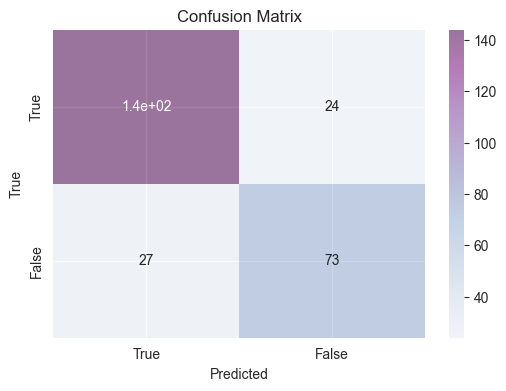

In [16]:
plt.figure(figsize=(6,4))
ax=sns.heatmap(confusion_matrix(y_test,pred),annot=True,cmap="BuPu",alpha=0.5)
ax.set(xlabel='Predicted',ylabel='True',title='Confusion Matrix',
            xticklabels=(['True', 'False']),
            yticklabels=(['True', 'False']))
plt.show()

In [17]:
### Un exemple utilisant un autre modèle, xgboost
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 6, 10, 15],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1],
    'scale_pos_weight': [1, 2, 3],
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss', 'error'],
    'tree_method': ['auto', 'hist', 'gpu_hist'],
    'booster': ['gbtree', 'dart'],
}

In [18]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
param_dist = {
    'learning_rate': uniform(0.01, 0.3),  # Uniform distribution between 0.01 and 0.3
    'n_estimators': randint(50, 300),  # Random integer between 50 and 300
    'max_depth': randint(3, 10),  # Random integer between 3 and 10
    'min_child_weight': randint(1, 6),  # Random integer between 1 and 6
    'subsample': uniform(0.6, 0.4),  # Uniform distribution between 0.6 and 1
    'colsample_bytree': uniform(0.6, 0.4),  # Uniform distribution between 0.6 and 1
    'gamma': uniform(0, 0.5),  # Uniform distribution between 0 and 0.5
    'reg_alpha': uniform(0, 1),  # L1 regularization
    'reg_lambda': uniform(0, 1),  # L2 regularization
    'scale_pos_weight': [1, 2, 3],  # Different scale for positive weight
    'booster': ['gbtree', 'dart'],  # Booster type
}

In [19]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of iterations
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [20]:
%%time
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:20:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:20:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:20:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:20:31] WARNING: /Users/runner/work/xgboost/xgboost/src

Best Hyperparameters: {'booster': 'gbtree', 'colsample_bytree': 0.8060944219456844, 'gamma': 0.48655517463505216, 'learning_rate': 0.19058061866228806, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 70, 'reg_alpha': 0.16893506307216455, 'reg_lambda': 0.2785903390319586, 'scale_pos_weight': 1, 'subsample': 0.6127218725940661}
Test Accuracy: 0.8246268656716418
CPU times: user 7.1 s, sys: 1.99 s, total: 9.09 s
Wall time: 17min 22s


## Faire un Bayesian 

    - Bayesian search, specifically BayesSearchCV in scikit-learn, is a hyperparameter optimization technique that uses a Bayesian approach to efficiently search the parameter space. Unlike random or grid search, which sample the space blindly or exhaustively, Bayesian search builds a probabilistic model of the objective function (e.g., cross-validation score) and uses it to guide the search towards promising regions.

In [21]:
search_space = {
    'learning_rate': Real(0.01, 0.3, prior='uniform'),
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 6),
    'subsample': Real(0.6, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.6, 1.0, prior='uniform'),
    'gamma': Real(0, 0.5, prior='uniform'),
    'reg_alpha': Real(0, 1, prior='uniform'),
    'reg_lambda': Real(0, 1, prior='uniform'),
    'scale_pos_weight': Integer(1, 3),
}

In [22]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [23]:
opt = BayesSearchCV(
    model,
    search_space,
    n_iter=50,  # Number of iterations to run the optimization
    scoring='accuracy',
    cv=5,
    n_jobs=-1,  # Use all available CPUs
    random_state=42,
    verbose=1
)

In [24]:
# Fit the model with the Bayesian optimization
opt.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", opt.best_params_)

# Evaluate the model on the test set
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:54] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:55] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:56] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:56] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:57] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:58] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:58] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:37:59] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:00] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:02] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:05] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:08] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:10] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:12] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:15] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:18] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:22] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:24] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:28] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:31] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:34] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:37] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:40] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:43] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:46] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:50] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:52] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:55] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:59] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:02] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:06] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:10] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:13] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:18] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:23] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:27] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:31] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:35] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:38] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:41] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:45] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:48] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:52] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:56] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:39:59] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:02] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:06] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:09] WARNING: /Users/runner/work/xgboost/xgboost/src

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:13] WARNING: /Users/runner/work/xgboost/xgboost/src

Best Hyperparameters: OrderedDict([('colsample_bytree', 0.6), ('gamma', 0.36565692919759335), ('learning_rate', 0.06712754366996554), ('max_depth', 3), ('min_child_weight', 6), ('n_estimators', 294), ('reg_alpha', 0.8697884449081932), ('reg_lambda', 0.9226255681157648), ('scale_pos_weight', 1), ('subsample', 0.6)])
Test Accuracy: 0.8432835820895522


## Utilisation d'optuna pour la recherche des meilleurs paramètres

In [25]:
def objective(trial):
    # Define hyperparameter search space
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0.0, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e2),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e2)
    }
    
    # Create the model
    model = XGBClassifier(**param)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Return accuracy as the objective to minimize/maximize (Optuna will maximize it)
    return accuracy

In [26]:
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=100)  # Run the optimization for 100 trials


[I 2024-11-20 14:40:15,759] A new study created in memory with name: no-name-b11385f9-fc68-4692-b4f4-82acd3e33fc2
[I 2024-11-20 14:40:16,833] Trial 0 finished with value: 0.6268656716417911 and parameters: {'max_depth': 8, 'learning_rate': 2.7816840414703635e-05, 'n_estimators': 395, 'subsample': 0.7812554895630662, 'colsample_bytree': 0.9994716496082372, 'gamma': 0.08510433779498072, 'reg_alpha': 0.942198381798057, 'reg_lambda': 0.02474765203963064}. Best is trial 0 with value: 0.6268656716417911.
[I 2024-11-20 14:40:17,397] Trial 1 finished with value: 0.8507462686567164 and parameters: {'max_depth': 8, 'learning_rate': 0.004336475100327726, 'n_estimators': 182, 'subsample': 0.8122004837767007, 'colsample_bytree': 0.9050905225672069, 'gamma': 0.7557453617148859, 'reg_alpha': 0.0006403259497107988, 'reg_lambda': 1.599986960314885e-05}. Best is trial 1 with value: 0.8507462686567164.
[I 2024-11-20 14:40:18,086] Trial 2 finished with value: 0.6268656716417911 and parameters: {'max_depth

In [27]:
print("Best Hyperparameters: ", study.best_params)
print("Best Accuracy: ", study.best_value)

Best Hyperparameters:  {'max_depth': 5, 'learning_rate': 0.0017487415450068635, 'n_estimators': 498, 'subsample': 0.6050660788358114, 'colsample_bytree': 0.8485013657132996, 'gamma': 0.4200808421884175, 'reg_alpha': 0.01635768248736588, 'reg_lambda': 0.00027010463358468283}
Best Accuracy:  0.8582089552238806


In [28]:
best_params = study.best_trial.params
print("Best Hyperparameters:", best_params)

# Create the model with the best hyperparameters
best_model = XGBClassifier(**best_params)

# Train the model on the entire training data (X_train and y_train)
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy of the Best Model:", accuracy)

Best Hyperparameters: {'max_depth': 5, 'learning_rate': 0.0017487415450068635, 'n_estimators': 498, 'subsample': 0.6050660788358114, 'colsample_bytree': 0.8485013657132996, 'gamma': 0.4200808421884175, 'reg_alpha': 0.01635768248736588, 'reg_lambda': 0.00027010463358468283}
Test Accuracy of the Best Model: 0.8582089552238806
